<a href="https://colab.research.google.com/github/tatianapg/abejas/blob/master/4_kaglegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.kaggle.com/laszlofazekas/cifar10-dcgan-example

In [2]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot


In [3]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [4]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [6]:
# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X


In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [10]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    # filename = 'generated_plot_e%03d.png' % (epoch+1)
    # pyplot.savefig(filename)
    pyplot.show()


In [11]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model.h5'
    g_model.save(filename)



170500096/170498071 [==============================] - 4s 0us/step
>1, 1/195, d1=0.698, d2=0.695 g=0.692
>1, 101/195, d1=0.339, d2=0.461 g=2.777
>Accuracy real: 67%, fake: 92%


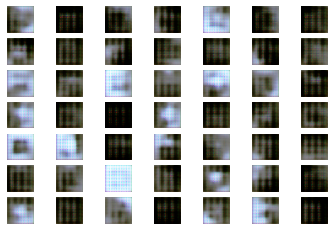

>2, 1/195, d1=0.485, d2=0.396 g=1.443
>2, 101/195, d1=0.425, d2=0.657 g=1.558
>Accuracy real: 80%, fake: 81%


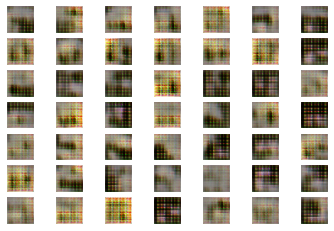

>3, 1/195, d1=0.518, d2=0.548 g=1.062
>3, 101/195, d1=0.537, d2=0.586 g=1.064
>Accuracy real: 47%, fake: 83%


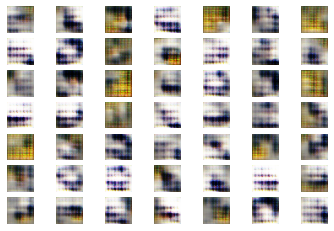

>4, 1/195, d1=0.619, d2=0.526 g=1.142
>4, 101/195, d1=0.572, d2=0.621 g=1.129
>Accuracy real: 67%, fake: 77%


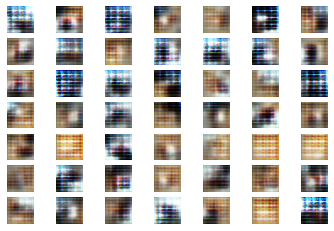

>5, 1/195, d1=0.597, d2=0.655 g=0.949
>5, 101/195, d1=0.699, d2=0.480 g=1.244
>Accuracy real: 68%, fake: 95%


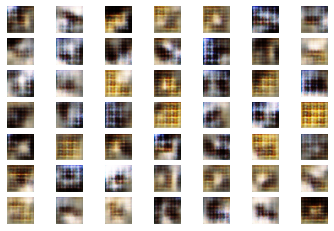

>6, 1/195, d1=0.562, d2=0.581 g=1.035
>6, 101/195, d1=0.597, d2=0.497 g=1.225
>Accuracy real: 66%, fake: 55%


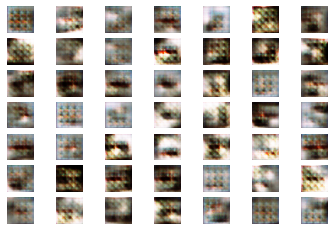

>7, 1/195, d1=0.658, d2=0.693 g=0.902
>7, 101/195, d1=0.601, d2=0.629 g=0.919
>Accuracy real: 51%, fake: 61%


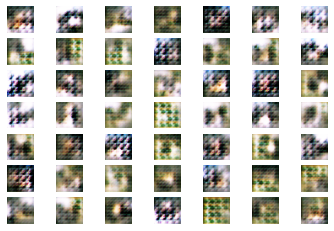

>8, 1/195, d1=0.671, d2=0.727 g=1.076
>8, 101/195, d1=0.595, d2=0.655 g=1.037
>Accuracy real: 69%, fake: 69%


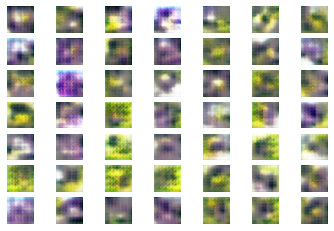

>9, 1/195, d1=0.594, d2=0.648 g=0.904
>9, 101/195, d1=0.531, d2=0.478 g=1.568
>Accuracy real: 67%, fake: 93%


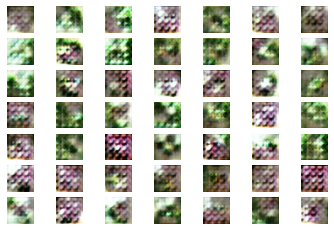

>10, 1/195, d1=0.455, d2=0.475 g=1.595
>10, 101/195, d1=0.629, d2=0.626 g=1.035
>Accuracy real: 81%, fake: 91%


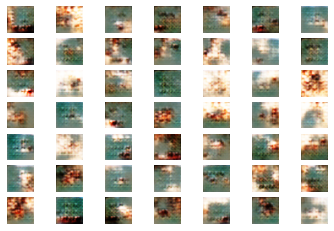

>11, 1/195, d1=0.432, d2=0.474 g=1.238
>11, 101/195, d1=0.597, d2=0.587 g=1.141
>Accuracy real: 57%, fake: 83%


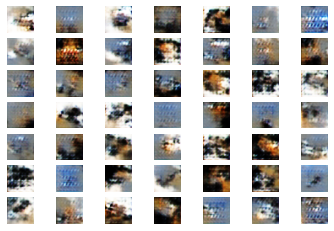

>12, 1/195, d1=0.585, d2=0.607 g=1.039
>12, 101/195, d1=0.697, d2=0.653 g=1.112
>Accuracy real: 62%, fake: 86%


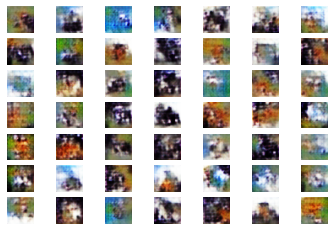

>13, 1/195, d1=0.522, d2=0.599 g=1.156
>13, 101/195, d1=0.509, d2=0.576 g=1.025
>Accuracy real: 60%, fake: 79%


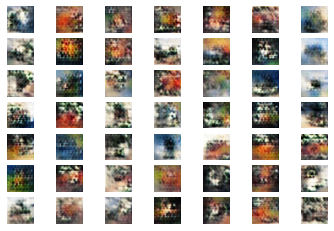

>14, 1/195, d1=0.600, d2=0.669 g=0.969
>14, 101/195, d1=0.698, d2=0.596 g=1.084
>Accuracy real: 51%, fake: 87%


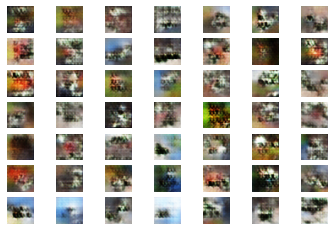

>15, 1/195, d1=0.584, d2=0.578 g=1.082
>15, 101/195, d1=0.668, d2=0.551 g=1.109
>Accuracy real: 44%, fake: 83%


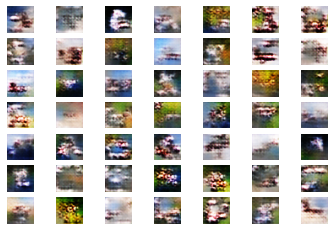

>16, 1/195, d1=0.612, d2=0.612 g=1.152
>16, 101/195, d1=0.574, d2=0.592 g=1.146
>Accuracy real: 55%, fake: 90%


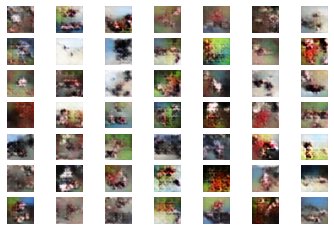

>17, 1/195, d1=0.588, d2=0.551 g=1.024
>17, 101/195, d1=0.623, d2=0.589 g=1.149
>Accuracy real: 56%, fake: 88%


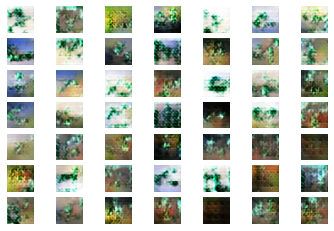

>18, 1/195, d1=0.552, d2=0.589 g=1.027
>18, 101/195, d1=0.536, d2=0.499 g=1.106
>Accuracy real: 53%, fake: 89%


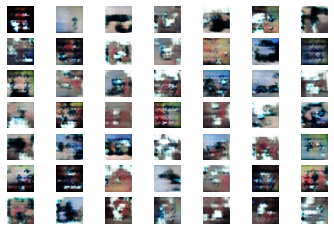

>19, 1/195, d1=0.589, d2=0.513 g=1.163
>19, 101/195, d1=0.600, d2=0.598 g=1.090
>Accuracy real: 46%, fake: 79%


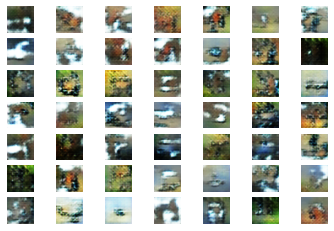

>20, 1/195, d1=0.616, d2=0.583 g=1.102
>20, 101/195, d1=0.642, d2=0.706 g=1.035
>Accuracy real: 61%, fake: 86%


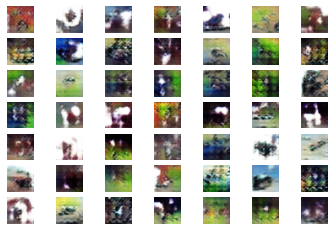

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            if j % 100 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        # if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, 20, 256)
